## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**Air-Sea CO₂ Flux, ECCO-Darwin Model**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/eccodarwin-co2flux-monthgrid-v5_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**: Global
- **Spatial resolution**: 1/3°
- **Temporal extent**: January 2020 - December 2022
- **Temporal resolution**: Monthly
- **Unit**: Millimoles of CO₂ per meter squared per second
- **Utility**: Climate Research, Oceanography, Carbon Stock Monitoring

For more, visit the [Air-Sea CO₂ Flux ECCO-Darwin Model](https://earth.gov/ghgcenter/data-catalog/eccodarwin-co2flux-monthgrid-v5) data overview page.  

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Air-Sea CO₂ Flux, ECCO-Darwin Model v5 Data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

## About the Data
#### Air-Sea CO₂ Flux ECCO-Darwin Model

The ocean is a major sink for atmospheric carbon dioxide (CO₂), largely due to the presence of phytoplankton that use the CO₂ to grow. Studies have shown that global ocean CO₂ uptake has increased over recent decades, however, there is uncertainty in the various mechanisms that affect ocean CO₂ flux and storage and how the ocean carbon sink will respond to future climate change.

Because CO₂ fluxes can vary significantly across space and time, combined with deficiencies in ocean and atmosphere CO₂ observations, there is a need for models that can thoroughly represent these processes. Ocean biogeochemical models (OBMs) can resolve the physical and biogeochemical mechanisms contributing to spatial and temporal variations in air-sea CO₂ fluxes but previous OBMs do not integrate observations to improve model accuracy and have not been able to operate on the seasonal and multi-decadal timescales needed to adequately characterize these processes.

The ECCO-Darwin model is an OBM that assimilates Estimating the Circulation and Climate of the Ocean (ECCO) consortium ocean circulation estimates and biogeochemical processes from the Massachusetts Institute of Technology (MIT) Darwin Project. A pilot study using ECCO-Darwin was completed by [Brix et al. (2015)](https://doi.org/10.1016/j.ocemod.2015.07.008) however, an improved version of the model was developed by [Carroll et al. (2020)](https://doi.org/10.1029/2019MS001888) in which issues present in the first model were addressed using data assimilation and adjustments were made to initial conditions and biogeochemical parameters. The updated ECCO-Darwin model was compared with interpolation-based products to estimate surface ocean partial pressure (pCO2) and air-sea CO₂ flux. This dataset contains the gridded global, monthly mean air-sea CO₂ fluxes from version 5 of the ECCO-Darwin model.

The data available in the US GHG Center hub are available at ~1/3° horizontal resolution at the equator (~18 km at high latitudes) from January 2020 through December 2022. For more information regarding this dataset, please visit the [Air-Sea CO₂ Flux ECCO-Darwin Model](https://earth.gov/ghgcenter/data-catalog/eccodarwin-co2flux-monthgrid-v5) data overview page.

## Terminology
Navigating data via the GHGC API, you will encounter terminology that is different from browsing in a typical filesystem. We'll define some terms here which are used throughout this notebook.
- `catalog`:    All datasets available at the `/stac` endpoint
- `collection`: A specific dataset, e.g. Air-Sea CO₂ Flux ECCO-Darwin Model
- `item`:       One granule in the dataset, e.g. one monthly file of fluxes
- `asset`:      A variable available within the granule, e.g. CO₂ fluxes
- `STAC API`:   **Sp**atio**T**emporal **A**sset **C**atalogs - Endpoint for fetching the data itself
- `Raster API`: Endpoint for fetching data, for imagery and statistics

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub, except the `tabulate` library. If you need to run this notebook elsewhere, please install the libraries by running the following command line:

%pip install requests folium rasterstats pystac_client pandas matplotlib tabulate --quiet

In [1]:
# Import the following libraries
# For fetching from the Raster API
import requests
# For making maps
import folium
import folium.plugins
from folium import Map, TileLayer
# For talking to the STAC API
from pystac_client import Client
# For working with data
import pandas as pd
# For making time series
import matplotlib.pyplot as plt
# For formatting date/time data
import datetime
# Custom functions for working with GHGC data via the API
import ghgc_utils

## Querying the STAC API
The libraries above allow better execution of a query in the GHG Center **Spatio Temporal Asset Catalog (STAC)** Application Programming Interface (API), where the granules for this collection are stored. You will learn the functionality of each library throughout the notebook.

### STAC API Collection Names

Now, you must fetch the dataset from the [**STAC API**](https://earth.gov/ghgcenter/api/stac/) by defining its associated STAC API collection ID as a variable. 
The collection ID, also known as the **collection name**, for the Air-Sea CO₂ Flux ECCO-Darwin Model dataset is [**eccodarwin-co2flux-monthgrid-v5**](https://earth.gov/ghgcenter/api/stac/collections/eccodarwin-co2flux-monthgrid-v5)

In [2]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable 
# Name of the collection for ECCO Darwin CO₂ flux monthly emissions
collection_name = "eccodarwin-co2flux-monthgrid-v5"

In [3]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac_client' library makes an HTTP request
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=eccodarwin-co2flux-monthgrid-v5>

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2020 to December 2022. By looking at the `dashboard:time density`, we observe that the data is periodic with monthly time density.

In [4]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 36 items


In [5]:
# The search function can be used to find data within a specific time frame, e.g. 2022.
search = catalog.search(
    collections=collection_name,
    datetime=['2021-01-01T00:00:00Z','2022-12-31T00:00:00Z']
)
# Take a look at the items we found
for item in search.item_collection():
    print(item)

<Item id=eccodarwin-co2flux-monthgrid-v5-202212>
<Item id=eccodarwin-co2flux-monthgrid-v5-202211>
<Item id=eccodarwin-co2flux-monthgrid-v5-202210>
<Item id=eccodarwin-co2flux-monthgrid-v5-202209>
<Item id=eccodarwin-co2flux-monthgrid-v5-202208>
<Item id=eccodarwin-co2flux-monthgrid-v5-202207>
<Item id=eccodarwin-co2flux-monthgrid-v5-202206>
<Item id=eccodarwin-co2flux-monthgrid-v5-202205>
<Item id=eccodarwin-co2flux-monthgrid-v5-202204>
<Item id=eccodarwin-co2flux-monthgrid-v5-202203>
<Item id=eccodarwin-co2flux-monthgrid-v5-202202>
<Item id=eccodarwin-co2flux-monthgrid-v5-202201>
<Item id=eccodarwin-co2flux-monthgrid-v5-202112>
<Item id=eccodarwin-co2flux-monthgrid-v5-202111>
<Item id=eccodarwin-co2flux-monthgrid-v5-202110>
<Item id=eccodarwin-co2flux-monthgrid-v5-202109>
<Item id=eccodarwin-co2flux-monthgrid-v5-202108>
<Item id=eccodarwin-co2flux-monthgrid-v5-202107>
<Item id=eccodarwin-co2flux-monthgrid-v5-202106>
<Item id=eccodarwin-co2flux-monthgrid-v5-202105>
<Item id=eccodarwin-

In [6]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

<Item id=eccodarwin-co2flux-monthgrid-v5-202212>

In [7]:
# Restructure our items into a dictionary where keys are the datetime items; we can then query more easily by date/time, e.g. "2020-02"
items_dict = {item.properties["start_datetime"][:7]: item for item in collection.get_items()}

Next, you will examine the contents of the `collection` under the `temporal` variable. You’ll see that the data is available from January 2020 to December 2022. Looking at the `dashboard:time density`, you can observe that the data is periodic with monthly time density.

In [8]:
# Before we go further, let's pick which asset to focus on for the remainder of the notebook.
# For this collection, there is only one asset to choose from: "co2".
asset_name = "co2"

# Create Maps Using Folium
You will now explore differences in Air-Sea CO₂ flux at two different date/times. You will visualize the outputs on a map using `folium`.

## Fetch Imagery from Raster API

Here we get information from the `Raster API` which we will add to our map in the next section.

Below, you will specify the upper and lower bounds of your desired colorbar for visualizing the data, which will be saved as `rescale_values`.

In [9]:
# Specify two dates/times to visualize.
dates = ["2020-01","2020-07"]

observation_date_1 = items[dates[0]]

# Extract collection name and item ID
collection_id = observation_date_1.collection_id
item_id = observation_date_1.id

TypeError: list indices must be integers or slices, not str

In [10]:
object = observation_date_1.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
raster_bands

NameError: name 'observation_date_1' is not defined

In [11]:
rescale_values = {
    "max": raster_bands[0]['statistics']['mean'] + 2*raster_bands[0]['statistics']['stddev'],
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)

NameError: name 'raster_bands' is not defined

Now, you will pass the `item id`, `collection name`, `asset name`, and the `rescale_values` to the `Raster API` endpoint. This step is done twice, once for each date/time you want to visualize.

In [12]:
# Choose a color for displaying the data
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "magma"

In [13]:
# Make a GET request to retrieve information for the date mentioned below
observation_date_1_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=-0.0007,0.0007"
).json()

# Print the properties of the retrieved granule to the console
observation_date_1_tile

NameError: name 'collection_id' is not defined

In [14]:
# Make a GET request to retrieve information for the date mentioned below
observation_date_2 = items[dates[1]]
# Extract collection name and item ID
collection_id = observation_date_2.collection_id
item_id = observation_date_2.id

observation_date_2_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=-0.0007,0.0007"
).json()

# Print the properties of the retrieved granule to the console
observation_date_2_tile

TypeError: list indices must be integers or slices, not str

## Map Out Selected Tiles
For this study, you are going to compare the CO₂ levels along the coast of California.

In [15]:
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement

# Set the initial zoom level and center of map for both tiles
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(41,-67), zoom_start=5)


# Define the first map layer with the CO2 Flux data for December 2022
map_layer_1 = TileLayer(
    tiles=observation_date_2_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name=f'{dates[0]} {items[dates[1]].assets[asset_name].title}', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the first layer to the Dual Map 
map_layer_1.add_to(map_.m1)


# Define the second map layer with the CO2 Flux data for April 2021
map_layer_2 = TileLayer(
    tiles=observation_date_1_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name=f'{dates[1]} {items[dates[1]].assets[asset_name].title}', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the second layer to the Dual Map 
map_layer_2.add_to(map_.m2)


# Display data markers (titles) on both maps
folium.Marker((41,-67)).add_to(map_)

# Add a layer control to switch between map layers
folium.LayerControl(collapsed=False).add_to(map_)

# Add colorbar
# First, scale our colorbar range to make the numbers display more neatly
for k in rescale_values.keys():
    rescale_values[k] = rescale_values[k]/1e19
# Next, call one of our custom 'ghgc_utils' functions to create an HTML colorbar representation.
legend_html = ghgc_utils.generate_html_colorbar(
                color_map,
                rescale_values,
                label='10^19 Millimoles per meter squared per second (mmol m²/s)'
    )

# Add colorbar to the map
map_.get_root().html.add_child(folium.Element(legend_html))

# Visualize the Dual Map
map_

NameError: name 'observation_date_2_tile' is not defined

In [16]:
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement

# Set the initial zoom level and center of map for both tiles
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(41,-67), zoom_start=5)


# Define the first map layer with the CO2 Flux data for December 2022
map_layer_1 = TileLayer(
    tiles=observation_date_2_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name=f'{dates[0]} CO2 Flux', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the first layer to the Dual Map 
map_layer_1.add_to(map_.m1)


# Define the second map layer with the CO2 Flux data for April 2021
map_layer_2 = TileLayer(
    tiles=observation_date_1_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name=f'{dates[1]} CO2 Flux', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the second layer to the Dual Map 
map_layer_2.add_to(map_.m2)


# Display data markers (titles) on both maps
folium.Marker((41,-67), tooltip="both").add_to(map_)

# Add a layer control to switch between map layers
folium.LayerControl(collapsed=False).add_to(map_)

# Add a legend to the dual map using the 'branca' library
# Note: the inserted legend is representing the minimum and maximum values for both tiles
# Minimum value = -0.0007, maximum value = 0.0007
#colormap = branca.colormap.LinearColormap(colors=["#0000FF", "#3399FF", "#66CCFF", "#FFFFFF", "#FF66CC", "#FF3399", "#FF0000"], vmin=-0.0007, vmax=0.0007) 

# Add the data unit as caption 


# Define custom tick values for the legend bar
#tick_val = [-0.0007, -0.00035, 0, 0.00035, 0.0007]

colormap = branca.colormap.linear.magma.scale(rescale_values['min']/1e19,rescale_values['max']/1e19)
colormap.caption = '10^19 Millimoles per meter squared per second (mmol m²/s)'
colormap.add_to(map_.m1)

# Create a HTML representation
#legend_html = colormap._repr_html_()

# Create a customized HTML structure for the legend
#legend_html = f'''
#<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; width: 400px; height: auto; background-color: rgba(255, 255, 255, 0.8);
#             border-radius: 5px; border: 1px solid grey; padding: 10px; font-size: 14px; color: black;">
#    <b>{colormap.caption}</b><br>
#    <div style="display: flex; justify-content: space-between;">
#        <div>{tick_val[0]}</div> 
#        <div>{tick_val[1]}</div> 
#        <div>{tick_val[2]}</div> 
#        <div>{tick_val[3]}</div> 
#        <div>{tick_val[4]}</div> 
#    </div>
#    <div style="background: linear-gradient(to right,
#                {'#0000FF'}, {'#3399FF'} {20}%,
#                {'#3399FF'} {20}%, {'#66CCFF'} {40}%,
#                {'#66CCFF'} {40}%, {'#FFFFFF'} {50}%,
#                {'#FFFFFF'} {50}%, {'#FF66CC'} {80}%,
#                {'#FF66CC'} {80}%, {'#FF3399'}); height: 10px;"></div>
#</div>
#'''

# Display the legend and caption on the map
#map_.get_root().html.add_child(folium.Element(legend_html))

# Visualize the Dual Map
map_

NameError: name 'observation_date_2_tile' is not defined

# Calculate Zonal Statistics
To perform zonal statistics, you first need to create a polygon. In this use case, you are creating a polygon along the coast of California, United States.

In [ ]:
# Give your AOI a name for use in the plot later
aoi_name = 'Coastal California'
# Define AOI as a GeoJSON
aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                [-124.19, 37.86], # North-west bounding coordinate
                [-123.11, 37.86], # North-east bounding coordinate
                [-119.96, 33.16], # South-east bounding coordinate
                [-121.13, 33.16], # South-west bounding coordinate
                [-124.19, 37.86]  # North-west bounding coordinate (closing the polygon)
            ]
        ],
        "type": "Polygon",
    },
}

Now that you created the polygon for the area of interest, you need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon. 

Before you run the generated function in the previous step on a specific item (observation), you need to check the total number of items available within the collection and retrieve the information regarding their start date-time.

In [ ]:
# Check the total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 36 items


In [ ]:
# Examine the first item in the collection
items[0]['properties']

{'end_datetime': '2022-12-31T00:00:00+00:00',
 'start_datetime': '2022-12-01T00:00:00+00:00'}

Generate the statistics for the AOI

In [11]:
for item in items:
    print(item['properties']['start_datetime'])

2022-12-01T00:00:00+00:00
2022-11-01T00:00:00+00:00
2022-10-01T00:00:00+00:00
2022-09-01T00:00:00+00:00
2022-08-01T00:00:00+00:00
2022-07-01T00:00:00+00:00
2022-06-01T00:00:00+00:00
2022-05-01T00:00:00+00:00
2022-04-01T00:00:00+00:00
2022-03-01T00:00:00+00:00
2022-02-01T00:00:00+00:00
2022-01-01T00:00:00+00:00
2021-12-01T00:00:00+00:00
2021-11-01T00:00:00+00:00
2021-10-01T00:00:00+00:00
2021-09-01T00:00:00+00:00
2021-08-01T00:00:00+00:00
2021-07-01T00:00:00+00:00
2021-06-01T00:00:00+00:00
2021-05-01T00:00:00+00:00
2021-04-01T00:00:00+00:00
2021-03-01T00:00:00+00:00
2021-02-01T00:00:00+00:00
2021-01-01T00:00:00+00:00
2020-12-01T00:00:00+00:00
2020-11-01T00:00:00+00:00
2020-10-01T00:00:00+00:00
2020-09-01T00:00:00+00:00
2020-08-01T00:00:00+00:00
2020-07-01T00:00:00+00:00
2020-06-01T00:00:00+00:00
2020-05-01T00:00:00+00:00
2020-04-01T00:00:00+00:00
2020-03-01T00:00:00+00:00
2020-02-01T00:00:00+00:00
2020-01-01T00:00:00+00:00


In [12]:
%%time

df = ghgc_utils.generate_stats(items,aoi,url=RASTER_API_URL,asset=asset_name)

Generating stats...
Done!
CPU times: user 114 ms, sys: 11.1 ms, total: 125 ms
Wall time: 10.7 s


In [2]:
# Display the stats for the first 5 granules in the collection
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

NameError: name 'df' is not defined

In [20]:
%%time 
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the aoi polygon
stats = {}
for item in items: 
    date = item["properties"]["start_datetime"]  # Get the associated date
    year_month = date[:7].replace('-', '')  # Convert datetime to year-month
    stats[year_month] = generate_stats(item, california_coast_aoi)

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-124.19, 37.86], [-123.11, 37.86], [-119.96, 33.16], [-121.13, 33.16], [-124.19, 37.86]]]}, 'properties': {'statistics': {'b1': {'min': -0.00010515466364758998, 'max': -2.6339156087043894e-05, 'mean': -6.713517054587462e-05, 'count': 86.62000274658203, 'sum': -0.005815248657075913, 'std': 1.9970110657389885e-05, 'median': -6.633380711657132e-05, 'majority': -0.00010515466364758998, 'minority': -0.00010515466364758998, 'unique': 115.0, 'histogram': [[9, 8, 9, 8, 22, 10, 18, 16, 8, 7], [-0.00010515466364758998, -9.727311289153537e-05, -8.939156213548077e-05, -8.151001137942615e-05, -7.362846062337154e-05, -6.574690986731694e-05, -5.786535911126232e-05, -4.9983808355207714e-05, -4.2102257599153106e-05, -3.422070684309849e-05, -2.6339156087043894e-05]], 'valid_percent': 31.94, 'masked_pixels': 245.0, 'valid_pixels': 115.0, 'percentile_2': -0.00010359588859230771, 'percentile_98': -3.194067887033325e-05}}}}
{'type': 'Feat

## Time-Series Analysis
You can now explore the fossil fuel emission using this data collection (January 2020 -December 2022) for the Coastal California region. You can plot the data set using the code below:

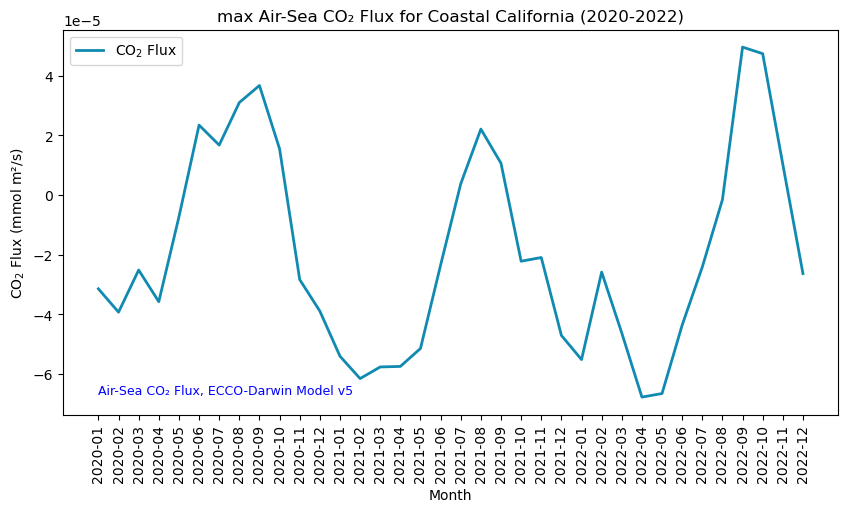

In [ ]:
# Sort the DataFrame by the datetime column so the plot displays the values from left to right (2020 -> 2022)
df_sorted = df.sort_values(by="datetime")

# Change which_stat to reflect which statistic you want to visualize in your time series plot - mean, min, max, etc.
which_stat = "max"

# Plot the timeseries analysis of the monthly air-sea CO₂ flux changes along the coast of California
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(10,5))
plt.plot(
    [d[0:7] for d in df_sorted["datetime"]],    # X-axis: sorted datetime, YYYY-MM only
    df_sorted[which_stat],         # Y-axis: maximum CO₂ value
    color="#118AB2",           # Line color, in hex format
    linestyle="-",            # Line style
    linewidth=2,              # Line width
    label="CO$_2$ Flux",    # Legend label
)

# Insert label for the X-axis
plt.xlabel("Month")

# Insert label for the Y-axis
plt.ylabel("CO$_2$ Flux (mmol m²/s)")

# Insert title for the plot
plt.title(f"{which_stat} {items[0]['assets'][asset_name]['title']} for {aoi_name} (2020-2022)")

# Insert legend
plt.legend()

# Rotate x-axis labels to avoid cramping
plt.xticks(rotation=90)

# Add data citation
plt.text(
    [d[0:7] for d in df_sorted["datetime"]][0],           # X-coordinate of the text (first datetime value)
    df_sorted[which_stat].min(),                  # Y-coordinate of the text (minimum CO2 value)

    # Text to be displayed
    f"{collection.title}",                   
    fontsize=9,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="bottom",              # Vertical alignment
    color="blue",                            # Text color
)

# Plot the time series
plt.show()

Here we can see the seasonal cycle of air-sea CO2 flux off the coast of California over the three relevant years.

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for the NASA Air-Sea CO₂ Flux ECCO Darwin dataset:
1.	Install and import the necessary libraries 
2.	Fetch the collection from STAC collections using the appropriate endpoints
3.	Count the number of existing granules within the collection
4.	Map and compare the CO₂ Flux levels over the Coastal California area for two distinctive months/years
5.	Create a table that displays the minimum, maximum, and sum of the CO₂ Flux values for a specified region
6.	Generate a time-series graph of the CO₂ Flux values for a specified region

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform). 